In [1]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn 

In [3]:
from google.colab import files
uploaded_train = files.upload()

Saving final-data-extended.csv to final-data-extended.csv


In [5]:
import io
train_df = pd.read_csv(io.BytesIO(uploaded_train['final-data-extended.csv']), delimiter=';')
train_df['topic'] = train_df['topic'].replace(['book','restaurant','movie'],[0,1,2])
train_df = train_df.drop(columns=['ID','sentiment'], axis=1)
train_df.head()

,text,topic
0,A tasty masala .,2
1,unnoticed,2
2,exists only,2
3,unstinting,2
4,of the funniest jokes of any movie,2


In [6]:
uploaded_test = files.upload()

Saving sentiment-topic-final-test.tsv to sentiment-topic-final-test.tsv


In [7]:
test_df = pd.read_csv(io.BytesIO(uploaded_test['sentiment-topic-final-test.tsv']), delimiter='\t')
test_df['topic'] = test_df['topic'].replace(['book','restaurant','movie'],[0,1,2])
test_df = test_df.drop(columns=['sentence id','sentiment'], axis=1)
test_df.head()

,text,topic
0,It took eight years for Warner Brothers to rec...,2
1,All the New York University students love this...,1
2,This Italian place is really trendy but they h...,1
3,"In conclusion, my review of this book would be...",0
4,The story of this movie is focused on Carl Bra...,2


In [8]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train_df, test_size=0.1, random_state=0, 
                               stratify=train_df[['topic']])
train.head()

,text,topic
17829,Piccoli 's,2
776,a rattling noise,2
2408,This is my first time to visit this Bakeshop b...,1
9056,This is a short fantastical story about writin...,0
17964,"This book was funny and interesting, it keep y...",0


In [9]:
dev.head()

,text,topic
14392,worth the price of admission,2
11518,Not the Sprinkles of Los Angeles. I used to be...,1
723,touching and tender,2
9156,It was delicious definitely going back a lot t...,1
11726,A fascinating documentary about the long and e...,2


In [10]:
sentences_train = []
sentences_test = []
sentences_dev = []
gold_labels_train = []
gold_labels_test = []
gold_labels_dev = []

for sentence in train['text']:
    sentences_train.append(sentence)

for topic in train['topic']:
    gold_labels_train.append(topic)
    
for sentence in test_df['text']:
    sentences_test.append(sentence)

for topic in test_df['topic']:
    gold_labels_test.append(topic)   
  
for sentence in dev['text']:
    sentences_dev.append(sentence)

for topic in dev['topic']:
    gold_labels_dev.append(topic)   

# print(len(sentences_train))
# print(len(sentences_dev))

In [11]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [12]:
model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=3, args=model_args, use_cuda=True) # CUDA is enabled

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [13]:
_, history = model.train_model(train, eval_df=dev) 

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/16199 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/507 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

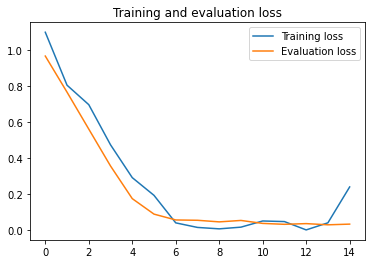

In [14]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [15]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]

{'mcc': 0.9908503063774722, 'eval_loss': 0.03462757388750712}

In [16]:
predicted, probabilities = model.predict(sentences_test)
test_df['predicted'] = predicted

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
test_df.head(10)

,text,topic,predicted
0,It took eight years for Warner Brothers to rec...,2,2
1,All the New York University students love this...,1,1
2,This Italian place is really trendy but they h...,1,1
3,"In conclusion, my review of this book would be...",0,0
4,The story of this movie is focused on Carl Bra...,2,0
5,Chris O'Donnell stated that while filming for ...,2,0
6,My husband and I moved to Amsterdam 6 years ag...,1,1
7,Dame Maggie Smith performed her role excellent...,2,2
8,The new movie by Mr. Kruno was shot in New Yor...,2,0
9,"I always have loved English novels, but I just...",0,0


In [18]:
print(classification_report(test_df['topic'], test_df['predicted']))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      1.00      1.00         3
           2       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.80      0.80      0.71        10
weighted avg       0.88      0.70      0.70        10

